In [ ]:
import os
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
import matplotlib.patches as patches
from PIL import Image
from tensorflow import keras
from google.colab import drive
from keras.layers import Dropout
from tensorflow.keras.preprocessing import image as keras_image
from tensorflow.keras.preprocessing.image import ImageDataGenerator


drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/Image_processing/Yossi')


# images and folders paths
TRAIN_DATA_PATH = "/content/drive/MyDrive/Image_processing/Yossi/train_data/train/"
TEST_DATA_PATH = "/content/drive/MyDrive/Image_processing/Yossi/train_data/test/"
FREE_TEST_PATH = "/content/drive/MyDrive/Image_processing/Yossi/train_data/test/empty/spot390.jpg"
CAR_TEST_PATH = "/content/drive/MyDrive/Image_processing/Yossi/train_data/test/occupied/spot115.jpg"

SAVED_MODEL_PATH = 'parking_lot_model.h5'

CAR_VAL = 1
FREE_VAL = 0
CAR_LABEL = 'occupied'
FREE_LABEL = 'free'

# classification model constants
INPUT_SHAPE = 60
BATCH_SIZE = 8
CLASS_MODE = 'binary'
OPTIMIZER = 'adam'
LOSS = 'binary_crossentropy'
EPOCHS = 10
STEPS_PER_EPOCH = 16
METRICS = ['accuracy']
DROPOUT_1 = 0.2
DROPOUT_2 = 0.5
CLASSIFIER_THRESHOLD = 0.5
LAYER_1_SIZE = 8
LAYER_2_SIZE = 16
LAYER_3_SIZE = 32
LAYER_4_SIZE = 64
LAYER_5_SIZE = 128
CONV_SIZE = (3,3)
ACTIVATION_FUNC = 'relu'
LAST_ACTIVATION_FUNC = 'sigmoid'
MAX_POOL = 2
PIXEL_COLORS = 3
RESCALE = 1/255
FONT_SIZE = 30

Mounted at /content/drive


In order to use Deep learning we'll train a binary classification model using Keras.
We're cutting empty and occupied parking lots from the video's frames and split them into train and test. 


In [ ]:
train = ImageDataGenerator(rescale=RESCALE)
test = ImageDataGenerator(rescale=RESCALE)

train_dataset = train.flow_from_directory(TRAIN_DATA_PATH,
                                          target_size=(INPUT_SHAPE,INPUT_SHAPE),
                                          batch_size = BATCH_SIZE,
                                          class_mode = CLASS_MODE)
                                         
test_dataset = test.flow_from_directory(TEST_DATA_PATH,
                                        target_size=(INPUT_SHAPE,INPUT_SHAPE),
                                        batch_size =BATCH_SIZE,
                                        class_mode = CLASS_MODE)


model = keras.Sequential()

# Convolutional layer and maxpool layer 1
model.add(keras.layers.Conv2D(LAYER_1_SIZE,CONV_SIZE,activation=ACTIVATION_FUNC,input_shape=(INPUT_SHAPE,INPUT_SHAPE,PIXEL_COLORS)))
model.add(keras.layers.MaxPool2D(MAX_POOL,MAX_POOL))
model.add(Dropout(DROPOUT_1))
# Convolutional layer and maxpool layer 2
model.add(keras.layers.Conv2D(LAYER_2_SIZE,CONV_SIZE,activation=ACTIVATION_FUNC))
model.add(keras.layers.MaxPool2D(MAX_POOL,MAX_POOL))

# Convolutional layer and maxpool layer 3
model.add(keras.layers.Conv2D(LAYER_3_SIZE,CONV_SIZE,activation=ACTIVATION_FUNC))
model.add(keras.layers.MaxPool2D(MAX_POOL,MAX_POOL))
model.add(Dropout(DROPOUT_2))
# Convolutional layer and maxpool layer 4
model.add(keras.layers.Conv2D(LAYER_4_SIZE,CONV_SIZE,activation=ACTIVATION_FUNC))
model.add(keras.layers.MaxPool2D(MAX_POOL,MAX_POOL))

# This layer flattens the resulting image array to 1D array
model.add(keras.layers.Flatten())

# Hidden layer with 512 neurons and Rectified Linear Unit activation function 
model.add(keras.layers.Dense(LAYER_5_SIZE,activation=ACTIVATION_FUNC, kernel_regularizer='l1'))

# Output layer with single neuron which gives 0 for Cat or 1 for Dog 
#Here we use sigmoid activation function which makes our model output to lie between 0 and 1
model.add(keras.layers.Dense(1,activation=LAST_ACTIVATION_FUNC))


model.compile(optimizer=OPTIMIZER,loss=LOSS,metrics=METRICS)
history = model.fit_generator(train_dataset,
         steps_per_epoch = STEPS_PER_EPOCH,
         epochs = EPOCHS, 
         validation_data = test_dataset,
         
         )

model.save(SAVED_MODEL_PATH)

Found 381 images belonging to 2 classes.
Found 164 images belonging to 2 classes.


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
16/16 [==============================] - 55s 3s/step - loss: 7.5684 - accuracy: 0.6837 - val_loss: 6.7154 - val_accuracy: 0.7683
Epoch 2/10
16/16 [==============================] - 16s 976ms/step - loss: 6.4312 - accuracy: 0.7518 - val_loss: 5.6333 - val_accuracy: 0.7683
Epoch 3/10
16/16 [==============================] - 8s 531ms/step - loss: 5.4216 - accuracy: 0.7601 - val_loss: 4.7182 - val_accuracy: 0.7683
Epoch 4/10
16/16 [==============================] - 7s 478ms/step - loss: 4.3901 - accuracy: 0.8226 - val_loss: 3.8563 - val_accuracy: 0.9207
Epoch 5/10
16/16 [==============================] - 6s 360ms/step - loss: 3.5605 - accuracy: 0.8563 - val_loss: 3.0641 - val_accuracy: 0.9024
Epoch 6/10
16/16 [==============================] - 3s 215ms/step - loss: 2.8417 - accuracy: 0.8387 - val_loss: 2.3477 - val_accuracy: 0.9390
Epoch 7/10
16/16 [==============================] - 3s 147ms/step - loss: 2.2003 - accuracy: 0.9010 - val_loss: 1.8542 - val_accuracy: 0.9207
Epoch 8

Now let create a prediction method which using the trained model above. 
We needed to pad the patches in order to predict the labels. 

In [ ]:
def predictImage_by_filename(filename):
    """
    Get a file name and predicting it label 
    """
    img1 = cv2.imread(filename)
    plt.imshow(img1)

    Y = cv2.resize(img1, (INPUT_SHAPE, INPUT_SHAPE))
    
    X = np.expand_dims(Y,axis=0)

    val = model.predict(X)
    if val > CLASSIFIER_THRESHOLD:  
        plt.xlabel(CAR_LABEL,fontsize=FONT_SIZE)
    else:
        plt.xlabel(FREE_LABEL,fontsize=FONT_SIZE)

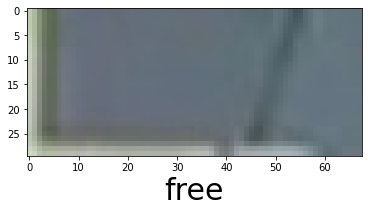

In [ ]:
FREE_TEST_PATH = "/content/drive/MyDrive/Image_processing/Yossi/train_data/test/empty/spot299.jpg"

predictImage_by_filename(FREE_TEST_PATH)




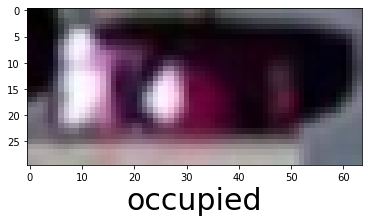

In [ ]:
predictImage_by_filename(CAR_TEST_PATH)

In [ ]:
test_dataset.class_indices

{'empty': 0, 'occupied': 1}

Now, let see how the train and test( loss and accuracy) learning curves looks like in order to ensure the learning process were "healty"

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


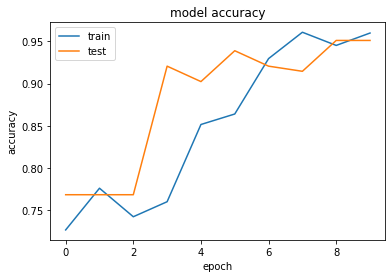

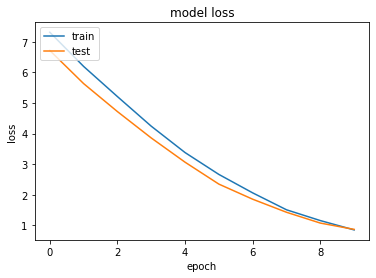

In [ ]:
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

We can see that the the loss curves(train and test) mostly went down and the accuracy mostly went up which means the learning process were succeeded with no overfitting.